In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np

In [2]:
data=pd.read_excel('Discharging 1- 28 (time).xlsx')
data

,time,V_m,Current (A),Cycle,Capacity,SoC,SoH,Capcyc,SoHcyc
0,2021-06-07 12:55:56.000,4.098,0.997,1,0.000277,99.990769,0.009231,2.840817,94.693889
1,2021-06-07 12:55:57.000,4.096,0.998,1,0.000554,99.981528,0.018472,2.840817,94.693889
2,2021-06-07 12:55:58.000,4.094,0.999,1,0.000832,99.972278,0.027722,2.840817,94.693889
3,2021-06-07 12:55:59.000,4.093,0.998,1,0.001109,99.963037,0.036963,2.840817,94.693889
4,2021-06-07 12:56:00.000,4.092,0.999,1,0.001386,99.953787,0.046213,2.840817,94.693889
...,...,...,...,...,...,...,...,...,...
276812,2021-06-14 21:23:43.002,2.509,1.000,28,2.666784,11.107194,88.892806,2.667898,88.929926
276813,2021-06-14 21:23:44.002,2.506,1.003,28,2.667063,11.097907,88.902093,2.667898,88.929926
276814,2021-06-14 21:23:45.002,2.504,1.003,28,2.667341,11.088620,88.911380,2.667898,88.929926
276815,2021-06-14 21:23:46.002,2.501,1.002,28,2.667620,11.079343,88.920657,2.667898,88.929926


## Y=SoH

In [6]:
X=data[['V_m','Current (A)','Capacity','SoC']]
y=data['SoH'].values
std=StandardScaler()
X_std=std.fit_transform(X)

train_size=int(0.7*len(X_std))
test_size=int(0.9*len(X_std))
X_train=X_std[:train_size] #70%
X_val=X_std[train_size:test_size] #20%
X_test=X_std[test_size:] #10%

y_train=y[:train_size]
y_val=y[train_size:test_size]
y_test=y[test_size:]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_4 (Dense)              (None, 32295)             193770    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 32296     
Total params: 226,091
Trainable params: 226,091
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
50/50 [==============================] - 5s 102ms/step - loss: 1661.9354 - mae: 16.5015 - mse: 1661.9354 - val_loss: 24.8267 - val_mae: 3.9378 - val_mse: 24.8267
Epoch 2/30
50/50 [==============================] - 5s 99ms/step - loss: 16.1701 - mae: 3.1150 - mse: 16.1701 - val_loss: 11.5494 - val_mae: 2.4701 - val_mse: 11.5494
Epoch 3/30
50/50 [=============

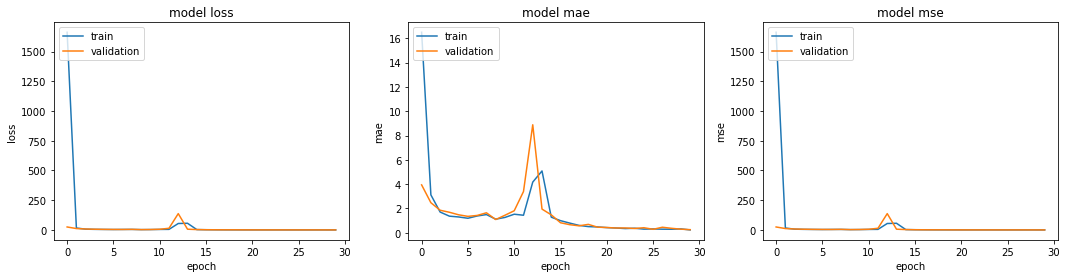

In [23]:
input_layers=X.shape[1]+1
output_layers=1
factor=1 #1-10
hidden_layers=int(len(X_train)/(factor*(input_layers+output_layers)))

model=tf.keras.Sequential([
    tf.keras.layers.Dense(input_layers, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'),
    tf.keras.layers.Dense(hidden_layers,activation='relu'),
    tf.keras.layers.Dense(output_layers,activation='linear')
])
print(model.summary())
print('\n')

model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.1),metrics=['mae','mse'])
history=model.fit(X_train,y_train,
                  epochs=30,
                  batch_size=100,
                  verbose=1,
                  steps_per_epoch=50,
                  validation_data=(X_val,y_val),
                  validation_steps=50,
                  validation_batch_size=150
                 )


fig,ax=pl.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['loss','mae','mse']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('model {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

Text(0, 0.5, 'Absolute Error %')

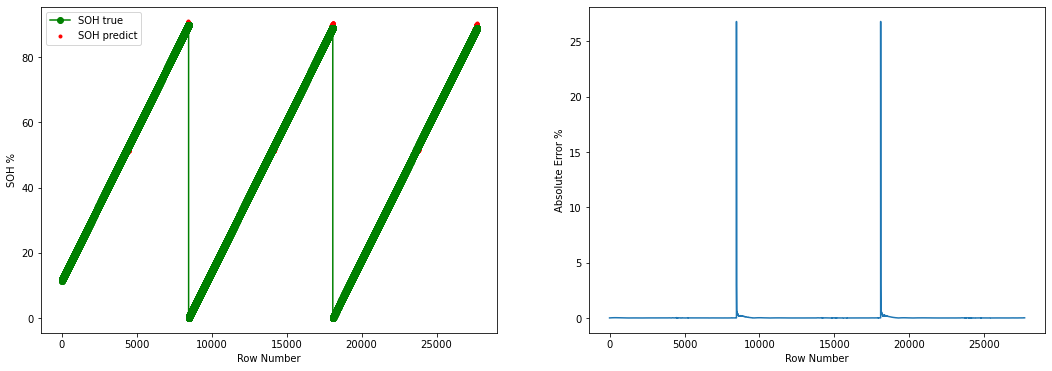

In [24]:
y_pred=model.predict(X_test)

fig,ax=pl.subplots(1,2,figsize=(18,6))
abs_error=np.abs(y_pred.reshape(-1)-y_test)/y_test

ax[0].scatter(range(len(X_test)),y_pred.reshape(-1),label='SOH predict',marker='.',color='red')
ax[0].plot(range(len(X_test)),y_test,label='SOH true',marker='o',color='green')
ax[0].set_xlabel('Row Number')
ax[0].set_ylabel('SOH %')
ax[0].legend()

ax[1].plot(range(len(X_test)),abs_error)
ax[1].set_xlabel('Row Number')
ax[1].set_ylabel('Absolute Error %')

In [ ]:
y_pred_all=model.predict(X_std).reshape(-1)

Text(0, 0.5, 'Absolute Error')

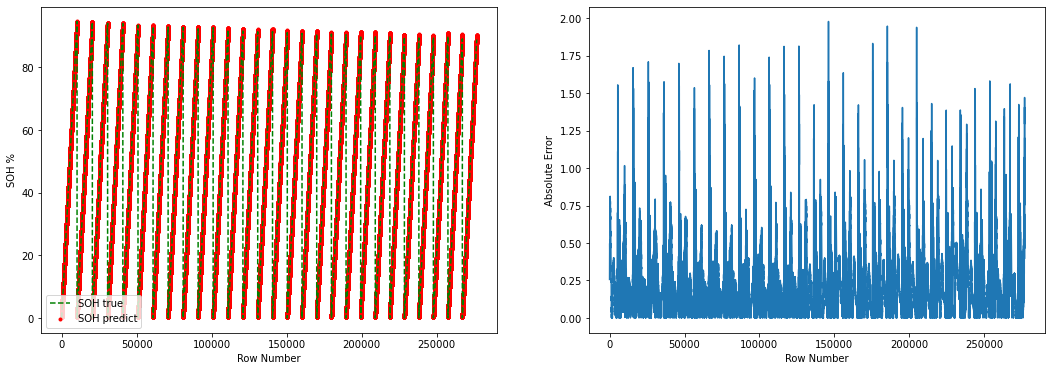

In [42]:
fig,ax=pl.subplots(1,2,figsize=(18,6))
abs_error=np.abs(y_pred_all-y)

ax[0].scatter(range(len(X_std)),y_pred_all,label='SOH predict',marker='.',color='red')
ax[0].plot(range(len(X_std)),y,label='SOH true',ls='--',color='green')
ax[0].set_xlabel('Row Number')
ax[0].set_ylabel('SOH %')
ax[0].legend(loc='lower left')

ax[1].plot(range(len(X)),abs_error)
ax[1].set_xlabel('Row Number')
ax[1].set_ylabel('Absolute Error')

In [1]:
print('mse:',np.mean((y_pred_all-y)**2))
print('mae:',np.mean(abs_error))

NameError: name 'np' is not defined

Text(0, 0.5, 'Relative Error (SOH true - SOH pred)')

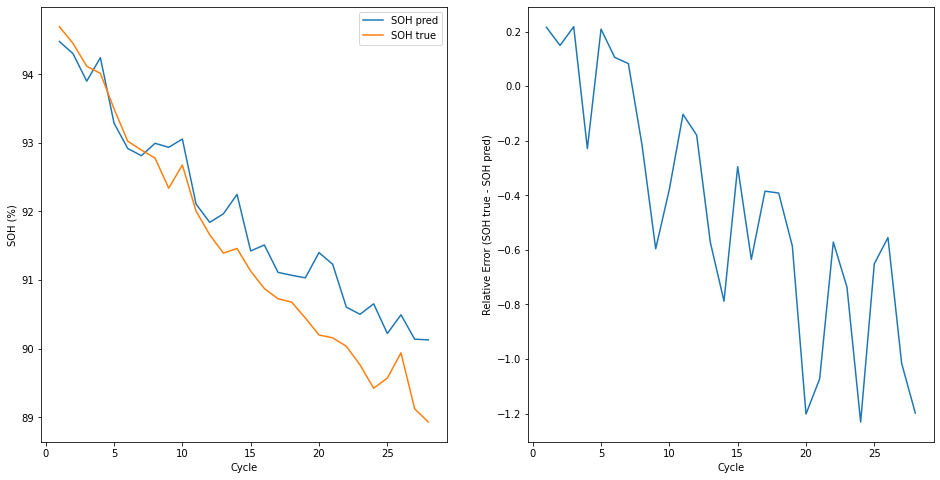

In [31]:
data['SOH_pred']=y_pred_all
data['selisih']=0
data['selisih']=data.SOH_pred.iloc[1:].reset_index(drop=True)-data.SOH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(16,8))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='SOH pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoH,label='SOH true')
ax[0].set_xlabel('Cycle')
ax[0].set_ylabel('SOH (%)')
#ax[0].set_ylim(80,95)
ax[0].legend()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoH-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SOH true - SOH pred)')